# Spatio-Temporal Traffic Forecasting with Neural Graph Cellular Automata
Petrônio C.  L. Silva  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-1202-2552" href="https://orcid.org/0000-0002-1202-2552" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Omid Orang  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-4077-3775" href="https://orcid.org/0000-0002-4077-3775" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Lucas Astore, Frederico G. Guimarães <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-9238-8839" href="https://orcid.org/0000-0001-9238-8839" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>

In case you have any questions, do not hesitate in contact us using the following e-mail: petronio.candido@ifnmg.edu.br


## Imports

In [37]:
from datetime import datetime, timezone, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from tensordict import TensorDict

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install torchmetrics
!pip install tensordict-nightly

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

## Embeddings

### Time Embedding

Neither DateTime or Timestamps exists in Torch tensor. So we will keep it in pandas datetimes.

In [28]:
def datetime_to_str(dt):
  return dt.strftime("%Y%m%d%H%M%S")

def to_pandas_datetime(values):
  return pd.to_datetime(values, format='%m/%d/%Y %H:%M')

def from_np_to_datetime(dt):
  return datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute)

def from_datetime_to_np(date : datetime):
  return np.datetime64(date.astimezone(timezone.utc))

class TemporalEmbedding(nn.Module):
  def __init__(self, dates, **kwargs):
    super().__init__()
    self.device = kwargs.get('device','cpu')
    self.dtype = kwargs.get('dtype',torch.float32)
    self.pi2 = torch.tensor([2 * torch.pi], dtype=self.dtype, device=self.device)
    self.week_minutes_rads = torch.tensor([(7 * 1440) * self.pi2], dtype=self.dtype, device=self.device)
    tmp_dict = {}
    self.length = 0
    for date in dates:
      tmp_dict[datetime_to_str(date)] = self.forward(date)
      self.length += 1 
    self.embeddings : TensorDict = TensorDict(tmp_dict) 

  def week_embedding(self, date):
      day_of_week = date.isocalendar()[2]  # Day of week (1: Monday, 7: Sunday)
      num = torch.tensor([day_of_week * 1440 + date.hour * 60 + date.minute], dtype=self.dtype, device=self.device)
      return torch.sin(num / self.week_minutes_rads)

  def minute_embedding(self, date):
    minute_of_day = torch.tensor([(date.hour * 60 + date.minute)/ 1440], dtype=self.dtype, device=self.device)
    return torch.sin(minute_of_day * self.pi2)
  
  def forward(self, dt):
     date = from_np_to_datetime(dt)
     we = self.week_embedding(date)
     me = self.minute_embedding(date)
     return torch.tensor([we, me], dtype=self.dtype, device=self.device)
  
  def __getitem__(self, date):
    if isinstance(date, np.datetime64):
      date =  from_np_to_datetime(date)
      return self.embeddings[datetime_to_str(date)]
    elif isinstance(date, datetime):
      return self.embeddings[datetime_to_str(date)]
    elif isinstance(date, int):
      return self.embeddings[date]
    else:
      raise Exception("Unknown index type")
    
  
  def all(self):
    ret = torch.empty(self.length, 2,
                        dtype=self.dtype, device=self.device)
    for it,emb in enumerate(self.embeddings.values(sort=True)):
      ret[it, :] = emb
    return ret
  
  def to(self, *args, **kwargs):
    self = super().to(*args, **kwargs)
    if isinstance(args[0], str):
      self.device = args[0]
    else:
      self.dtype = args[0]
    self.pi2 = self.pi2.to(*args, **kwargs)
    self.week_minutes_rads = self.week_minutes_rads.to(*args, **kwargs)
    return self

In [29]:
data_file  = 'C:\\Users\\petro\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\PEMS03_data_THIS_ONE.csv'
data = pd.read_csv(data_file)
data['timestamp']= to_pandas_datetime(data['timestamp'].values)

te = TemporalEmbedding(data['timestamp'])

te[data['timestamp'][0]]

tensor([0.1360, 0.0000])

In [30]:
from_datetime_to_np(from_np_to_datetime(data['timestamp'][0]))

C:\Users\petro\AppData\Local\Temp\ipykernel_28564\2097255585.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  return np.datetime64(date.astimezone(timezone.utc))


numpy.datetime64('2018-09-01T03:00:00.000000')

### Spatial Embedding

In [5]:
class SpatialEmbedding(nn.Module):
  def __init__(self, graph, laplacian_components = 2, **kwargs):
    super().__init__()
    self.device = kwargs.get('device','cpu')
    self.dtype = kwargs.get('dtype',torch.float32)
    tmp_dict = {}
    lat_dict = nx.get_node_attributes(graph,'lat')
    lon_dict = nx.get_node_attributes(graph,'lon')

    lat = [v for v in lat_dict.values()]
    lon = [v for v in lon_dict.values()]
    lat_min, lat_max = np.min(lat), np.max(lat)
    lat_rng = lat_max-lat_min
    lon_min, lon_max = np.min(lon), np.max(lon)
    lon_rng = lon_max-lon_min

    M = nx.adjacency_matrix(graph).todense()
    laplacian = SpectralEmbedding(n_components=laplacian_components) #, affinity='precomputed')
    laplacian_map = laplacian.fit_transform(M)

    print(laplacian_map.shape)

    self.length = 0
    for ix, node in enumerate(graph.nodes()):
        emb = np.zeros(4)
        emb[0] = (lat_dict[node] - lat_min) / lat_rng * 2 - 1
        emb[1] = (lon_dict[node] - lon_min) / lon_rng * 2 - 1
        emb[2:] = laplacian_map[ix,:]
        tmp_dict[str(node)] = torch.tensor(emb, dtype = self.dtype, device = self.device)
        self.length += 1

    self.embeddings = TensorDict(tmp_dict) 
    
  def forward(self, node):
     return self.embeddings[str(node)]
  
  def __getitem__(self,  node):
     return self.embeddings[str(node)]
  
  def all(self):
    ret = torch.empty(self.length, 4,
                        dtype=self.dtype, device=self.device)
    for it,emb in enumerate(self.embeddings.values(sort=True)):
      ret[it, :] = emb
    return ret
  
  def to(self, *args, **kwargs):
    self = super().to(*args, **kwargs)
    if isinstance(args[0], str):
      self.device = args[0]
    else:
      self.dtype = args[0]
    self.embeddings = self.embeddings.to(*args, **kwargs)

    return self

### Z-Transform

In [6]:
class ZTransform(nn.Module):
  def __init__(self, data, **kwargs):
    super().__init__()
    self.device = kwargs.get('device','cpu')
    self.dtype = kwargs.get('dtype',torch.float32)
    data = torch.tensor(data, dtype=self.dtype, device=self.device)
    self.mu = torch.mean(data)
    self.sigma = torch.std(data)
    
  def forward(self, x):
     return (x - self.mu) / self.sigma
  
  def to(self, *args, **kwargs):
    self = super().to(*args, **kwargs)
    if isinstance(args[0], str):
      self.device = args[0]
    else:
      self.dtype = args[0]
    self.mu = self.mu.to(*args, **kwargs)
    self.sigma = self.sigma.to(*args, **kwargs)

    return self

### Tokenizer

In [47]:
class NeighborhoodTokenizer(nn.Module):
  def __init__(self, **kwargs):
    super().__init__()

    self.NULL_SYMBOL = -99

    self.device = kwargs.get('device','cpu')
    self.dtype = kwargs.get('dtype',torch.float32)

    self.graph = kwargs.get('graph',None)

    self.num_nodes = kwargs.get('num_nodes',None)
    self.max_length = kwargs.get('max_length',None)
    self.token_dim = kwargs.get('token_dim',None)

    self.ztransform = kwargs.get('ztransform',None)
    self.spatial_embedding = kwargs.get('spatial_embedding',None)
    self.temporal_embedding = kwargs.get('temporal_embedding',None)

  def normalized_data(self, data, sensor):
    if isinstance(data, pd.DataFrame):
      values = data[str(sensor)].values
    elif isinstance(data, TensorDict):
      values = data[str(sensor)]
                
    return self.ztransform(torch.tensor(values, dtype=self.dtype, device=self.device))
    
  def normalized_sample(self, data, sensor, index):
    if isinstance(data, pd.DataFrame):
      value = data[str(sensor)].values[index]
    elif isinstance(data, TensorDict):
      value = data[str(sensor)]
    return self.ztransform(torch.tensor(value, dtype=self.dtype, device=self.device))
  
  
  def tokenize(self, timestamp, values, node):
    val = self.ztransform(values[str(node)])
    tim_emb = self.temporal_embedding(timestamp)

    tokens = self.spatial_embedding[node]
    tokens = torch.hstack([tokens, val ])
    tokens = torch.hstack([tokens, tim_emb])

    m = 1

    for neighbor in self.graph.neighbors(node):
      m += 1
      tokens = torch.hstack([tokens, self.spatial_embedding[neighbor]])
      tokens = torch.hstack([tokens, self.ztransform(values[str(neighbor)])])
      tokens = torch.hstack([tokens, tim_emb])

    tokens = tokens.reshape(1, m, self.token_dim)

    tokens = torch.hstack([tokens, torch.full((1, self.max_length - m, self.token_dim), self.NULL_SYMBOL)])

    return tokens
  
  # Create an empty sequence of tokens (filled with -1)
  # Then extracts the data for a sensor and its neighbors and fill the values
  # in the tokens, together with the spatial and temporal embeddings
  def tokenize_all(self, data, sensor):

    tmp = self.normalized_data(data, sensor)
    n = len(tmp)
    tim_emb = self.temporal_embedding.all().reshape(n,2)

    tokens = self.spatial_embedding[sensor].repeat(n,1)
    tokens = torch.hstack([tokens, tmp.reshape(n,1) ])
    tokens = torch.hstack([tokens, tim_emb])

    m = 1

    for neighbor in self.graph.neighbors(sensor):
      m += 1
      tokens = torch.hstack([tokens, self.spatial_embedding[neighbor].repeat(n,1)])
      tokens = torch.hstack([tokens, self.normalized_data(data, neighbor).reshape(n,1) ])
      tokens = torch.hstack([tokens, tim_emb])

    tokens = tokens.reshape(n, m, self.token_dim)


    tokens = torch.hstack([tokens, torch.full((n,  self.max_length - m, self.token_dim), self.NULL_SYMBOL)])

    return tokens

  def tokenize_sample(self, data, node, index):

    if isinstance(data, pd.DataFrame):
      dt = data['timestamp'][index]
    elif isinstance(data, TensorDict):
      dt = index

    tim_emb = self.temporal_embedding[dt]

    tokens = self.spatial_embedding[node]
    tokens = torch.hstack([tokens, self.normalized_sample(data, node, index)])
    tokens = torch.hstack([tokens, tim_emb])

    m = 1

    for neighbor in self.graph.neighbors(node):
      m += 1
      tokens = torch.hstack([tokens, self.spatial_embedding[neighbor]])
      tokens = torch.hstack([tokens, self.normalized_sample(data, neighbor, index)])
      tokens = torch.hstack([tokens, tim_emb])

    tokens = tokens.reshape(1, m, self.token_dim)

    tokens = torch.hstack([tokens, torch.full((1, self.max_length - m, self.token_dim), self.NULL_SYMBOL)])

    return tokens.reshape(self.max_length, self.token_dim)
    
  def forward(self, data, node, sample=None, **kwargs):
     if sample is None:
       return self.tokenize_all(data, node)
     else:
       return self.tokenize_sample(data, node, sample)
  
  def to(self, *args, **kwargs):
    self = super().to(*args, **kwargs)
    if isinstance(args[0], str):
      self.device = args[0]
    else:
      self.dtype = args[0]
    self.ztransform = self.ztransform.to(*args, **kwargs)
    self.spatial_embedding = self.spatial_embedding.to(*args, **kwargs)
    self.temporal_embedding = self.temporal_embedding.to(*args, **kwargs)
    return self

## Data

### PEMS03 Class

In [48]:
class PEMS03:

    def __init__(self,**kwargs):

      self.dtype = kwargs.get('dtype',torch.float64)
      self.device = kwargs.get('device','cpu')

      edges = pd.read_csv(kwargs.get('edges_file',edges_file))
      nodes = pd.read_csv(kwargs.get('nodes_file',nodes_file))
      self.data = pd.read_csv(kwargs.get('data_file',data_file))
      self.data['timestamp']= pd.to_datetime(self.data['timestamp'].values, format='%m/%d/%Y %H:%M')

      self.ztransform = ZTransform(torch.tensor(self.data[self.data.columns[1:]].values,
                                                dtype=self.dtype, device=self.device),
                                                dtype=self.dtype, device=self.device)

      # Create the graph
      self.G=nx.Graph()
      for row in edges.iterrows():
        self.G.add_edge(int(row[1]['source']),int(row[1]['target']), weight=row[1]['weight'])

      del(edges)

      coordinates = {}

      for ix, node in enumerate(self.G.nodes()):

        _, lat, lon = nodes[nodes['sensor'] == node].values[0]

        coordinates[node] = {'lat': lat, 'lon': lon }

      nx.set_node_attributes(self.G, coordinates)

      self.node_embeddings = SpatialEmbedding(self.G, dtype=self.dtype, device=self.device)

      # The maximum sequence length is equal to the maximum graph degree, or the
      # maximum number of neighbors a node have in the graph
      self.max_length = max([d for n, d in self.G.degree()]) + 1

      # precompute and store all time embeddings to save processing
      self.time_embeddings = TemporalEmbedding(self.data['timestamp'], dtype=self.dtype, device=self.device)

      self.num_sensors = len(nodes)

      del(nodes)

      self.num_samples = len(self.data)
      self.token_dim = 7

      self.value_index = 4

      self.tokenizer = NeighborhoodTokenizer(dtype = self.dtype, device = self.device,
                                             graph = self.G, num_nodes = self.num_sensors,
                                             max_length = self.max_length, 
                                             token_dim = self.token_dim, 
                                             ztransform = self.ztransform,
                                             spatial_embedding = self.node_embeddings,
                                             temporal_embedding = self.time_embeddings)

    

    # Will returna a SensorDataset filled with the sensor & neighbors preprocessed data (X)
    # and the expected values for t+y (y)
    def get_sensor_dataset(self, sensor, train = 0.7, dtype = torch.float64, **kwargs):
      X = self.tokenizer.tokenize_all(self.data, sensor)[:-1]
      y = torch.tensor(self.data[str(sensor)].values[1:], dtype=self.dtype, device=self.device)
      return SensorDataset(str(sensor),X,y,train, dtype, num_features = self.num_sensors,
                           max_length=self.max_length, token_dim=self.token_dim,
                           value_index=self.value_index, **kwargs)

    def get_fewsensors_dataset(self, sensors, train = 0.7, dtype = torch.float64, **kwargs):
      X = None
      y = None
      try:
        for sensor in sensors:
          tmpX = self.tokenizer.tokenize_all(self.data, sensor)[:-1]
          tmpy = torch.tensor(self.data[str(sensor)].values[1:], dtype=self.dtype, device=self.device)
          if X is None:
            X = tmpX
            y = tmpy
          else:
            #X = np.vstack((X,tmpX))
            X = torch.vstack((X,tmpX))
            #y = np.hstack((y,tmpy))
            y = torch.hstack((y,tmpy))
      except Exception as ex:
        print(sensor, str(ex))

      return SensorDataset('FEW',X,y,train, dtype, num_features = self.num_sensors,
                           max_length=self.max_length, token_dim=self.token_dim,
                           value_index=self.value_index, **kwargs)

    
    def get_breadth_dataset(self, start_sensor, max_sensors = 20, train = 0.7, dtype = torch.float64, **kwargs):
      sensors = []
      next = [start_sensor]
      m = 0
      while m < max_sensors:
        for sensor in next:
          sensors.append(sensor)
          m += 1
          next.remove(sensor)
          if m < max_sensors:
            for neighbor in self.G.neighbors(sensor):
              next.append(neighbor)
          else:
            break

      return self.get_fewsensors_dataset(sensors, train = train, dtype = dtype, **kwargs), sensors

    def plot_embeddings(self, limit=5000):
      pos_latlon = nx.circular_layout(self.G)
      pos_graph = nx.circular_layout(self.G)
      lat_max, lat_min = -np.inf, np.inf
      lon_max, lon_min = -np.inf, np.inf

      graph1_max, graph1_min = -np.inf, np.inf
      graph2_max, graph2_min = -np.inf, np.inf

      for node in self.G.nodes():
          emb = self.node_embeddings[node]
          pos_graph[node] = emb[0:2]
          pos_latlon[node] = emb[2:4]

          lat_max, lat_min = max(lat_max, pos_latlon[node][0]), min(lat_min, pos_latlon[node][0])
          lon_max, lon_min = max(lon_max, pos_latlon[node][1]), min(lon_min, pos_latlon[node][1])

          graph1_max, graph1_min = max(graph1_max, pos_graph[node][0]), min(graph1_min, pos_graph[node][0])
          graph2_max, graph2_min = max(graph2_max, pos_graph[node][1]), min(graph2_min, pos_graph[node][1])

      fig, ax = plt.subplots(1, 3, figsize=(15,5))
      nx.draw(self.G, pos_latlon, node_size=25, ax=ax[0], hide_ticks=False)
      ax[0].set_xlim([lat_min, lat_max])
      ax[0].set_ylim([lon_min, lon_max])
      xticks = [k for k in np.linspace(lat_min, lat_max, 5)]
      ax[0].set_xticks(xticks, [str(k) for k in xticks])
      yticks = [k for k in np.linspace(lon_min, lon_max, 5)]
      ax[0].set_yticks(yticks, [str(k) for k in yticks])
      ax[0].tick_params(labelleft=True)

      nx.draw(self.G, pos_graph, node_size=25, ax=ax[1], hide_ticks=False)
      ax[1].set_xlim([graph1_min, graph1_max])
      ax[1].set_ylim([graph2_min, graph2_max])

      ax[2].plot(self.time_embeddings[:limit, 0], color='red', label='Weekly seasonality')
      ax[2].plot(self.time_embeddings[:limit, 1], color='blue', label='Hourly seasonality')
      #ax[2].legend(loc='upper right')
      #limits = plt.axis("on")  # turn off axis
      plt.show()
      #plt.show()


base = 'C:\\Users\\petro\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\'

edges_file = base + 'PEMS03.csv'
nodes_file = base + 'pems03_preprocessed.csv'
data_file = base + 'PEMS03_data_THIS_ONE.csv'

pems=PEMS03(edges_file=edges_file, nodes_file=nodes_file, data_file=data_file)

C:\Users\petro\AppData\Local\Temp\ipykernel_28564\3884257881.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=self.dtype, device=self.device)


(358, 2)


In [9]:
pems.tokenizer.tokenize_sample(pems.data, 317141, 10)
#pems.tokenizer.tokenize_all(pems.data, 317141)

tensor([[-1.0000e+00,  2.0378e-01,  7.0394e-04,  1.6078e-04, -4.6803e-01,
          1.3678e-01,  2.1644e-01],
        [-9.8811e-01,  1.9428e-01, -5.1730e-03, -8.3282e-05, -9.2034e-01,
          1.3678e-01,  2.1644e-01],
        [-9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01,
         -9.9000e+01, -9.9000e+01],
        [-9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01,
         -9.9000e+01, -9.9000e+01],
        [-9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01,
         -9.9000e+01, -9.9000e+01],
        [-9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01,
         -9.9000e+01, -9.9000e+01],
        [-9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01, -9.9000e+01,
         -9.9000e+01, -9.9000e+01]], dtype=torch.float64)

### Sensor Dataset

In [10]:
class SensorDataset(Dataset):
  def __init__(self, name, X, y, train = 0.7,
               dtype = torch.float64, **kwargs):
    super().__init__()

    self.NULL_SYMBOL = -99

    self.behavior = kwargs.get('behavior','deterministic')

    self.num_samples = len(X)

    self.num_features = kwargs.get('num_features',0)

    self.max_length = kwargs.get('max_length',0)

    self.token_dim = kwargs.get('token_dim',0)

    self.value_index= kwargs.get('value_index',0)

    self.name = name
    self.dtype = dtype
    self.device = kwargs.get('device','cpu')

    self.X = X.to(self.dtype).to(self.device)
    self.y = y.to(self.dtype).to(self.device)

    self.indexes = torch.randperm(self.num_samples)

    self.X = self.X[self.indexes]
    self.y = self.y[self.indexes]

    self.train_split = int(train * self.num_samples)
    self.is_validation = False

  def train(self) -> Dataset:
    tmp = copy.deepcopy(self)
    tmp.is_validation = False
    tmp.X = self.X[:self.train_split].to(self.device)
    tmp.y = self.y[:self.train_split].to(self.device)
    tmp.num_samples = tmp.X.size(0)
    return tmp

  def test(self) -> Dataset:
    tmp = copy.deepcopy(self)
    tmp.is_validation = True
    tmp.X = self.X[self.train_split:].to(self.device)
    tmp.y = self.y[self.train_split:].to(self.device)
    tmp.num_samples = tmp.X.size(0)
    return tmp

  # Make this function stochastic!
  # Sometimes X will return the full information,sometimes X will miss some part of the information,
  # and sometimes will return with corrupted information (add noise)
  def __getitem__(self, index):
    if self.behavior == 'deterministic':
      return self.X[index], self.y[index]
    else:
      x = torch.clone(self.X[index])
      r = np.random.rand()
      if r >= .7:
        x[0,self.value_index] = torch.tensor([self.NULL_SYMBOL], dtype = self.dtype, device=self.device)
        #x[1:,:] = torch.full((self.max_length-1, self.token_dim),self.NULL_SYMBOL, dtype = self.dtype)
      elif r >= .5:
        x[1:,:] = torch.full((self.max_length-1, self.token_dim),self.NULL_SYMBOL, dtype = self.dtype, device=self.device)
      elif r >= .35:
        x[:,self.value_index] = x[:,self.value_index] + torch.randn(self.max_length, dtype = self.dtype, device=self.device)/12

      return x, self.y[index]

  def __len__(self):
    return self.num_samples

  def __iter__(self):
    for ix in range(self.num_samples):
      yield self[ix]

  def __str__(self):
    return "Dataset {}: {} attributes {} samples".format(self.name, self.num_attributes, self.num_samples)
  
  def to(self, *args, **kwargs):
    if isinstance(args[0], str):
      self.device = args[0]
    else:
      self.dtype = args[0]
    self.X = self.X.to(*args, **kwargs)
    self.y = self.y.to(*args, **kwargs)
    return self

In [54]:
class AllSensorDataset(Dataset):
  def __init__(self, pems, train = 0.7,
               dtype = torch.float64, **kwargs):
    super().__init__()

    self.pems = pems

    self.behavior = kwargs.get('behavior','deterministic')

    self.offset = kwargs.get('offset',0)
    self.samples = kwargs.get('samples',pems.num_samples * pems.num_sensors)


    self.dtype = dtype

    self.indexes = torch.randperm(self.samples) + self.offset

    self.train_pct = train

    self.train_split = int(train * self.samples)
    self.is_validation = False

  def train(self) -> Dataset:
    tmp = AllSensorDataset(self.pems, train_split = self.train_pct, dtype=self.dtype, offset = 0, samples = self.train_split)
    tmp.is_validation = False
    return tmp

  def test(self) -> Dataset:
    tmp = AllSensorDataset(self.pems, train_split = self.train_pct, dtype=self.dtype, offset = self.train_split, samples = (self.pems.num_samples * self.pems.num_sensors) - self.train_split)
    tmp.is_validation = True
    return tmp

  def __getitem__(self, index):
    #print(index)
    new_ix = self.indexes[index].item()
    #new_ix = index
    #print(new_ix)
    sensor = self.pems.inverse_sensor_indexes[ new_ix // self.pems.num_samples ]
    sensor_ix = new_ix % self.pems.num_samples
    x = self.pems.tokenize_sample(sensor, sensor_ix )
    y = self.pems.data[str(sensor)].values[sensor_ix+ 1] if sensor_ix < self.pems.num_samples - 1 else self.pems.data[str(sensor)].values[sensor_ix]
    x = torch.from_numpy(np.array([x])).to(self.dtype).squeeze()
    y = torch.from_numpy(np.array([y])).to(self.dtype)
    if self.behavior == 'deterministic':
      return x, y
    else:
      x = self.X[index]
      r = np.random.rand()
      if r >= .7:
        x[self.pems.value_index] = torch.tensor([self.pems.NULL_SYMBOL], dtype = self.dtype)
        x[1:] = torch.full((self.pems.max_length-1, self.pems.token_dim),self.pems.NULL_SYMBOL, dtype = self.dtype)
      elif r >= .5:
        x[1:] = torch.full((self.pems.max_length-1, self.pems.token_dim),self.pems.NULL_SYMBOL, dtype = self.dtype)
      elif r >= .3:
        x[self.pems.value_index] = x[self.pems.value_index] + torch.randn(self.pems.max_length, dtype = self.dtype)

      return x, y

  def __len__(self):
    return self.samples

  def __iter__(self):
    for ix in range(self.samples):
      yield self[ix]

  def __str__(self):
    return "Dataset {}: {} attributes {} samples".format(self.name, self.num_attributes, self.num_samples)

### PEMS03 Tests

In [92]:
ds = pems.get_fewsensors_dataset([314697, 315938, 312900], dtype=torch.float32)
ds[0]

(tensor([[-0.8353,  0.1061, -0.0030, -0.0013, -0.7881,  0.1143,  0.2377],
         [-0.8535,  0.1128,  0.0325,  0.0962, -1.0665,  0.1143,  0.2377],
         [-0.8641,  0.1167,  0.0325,  0.0962, -0.8647,  0.1143,  0.2377],
         [-0.8535,  0.1128,  0.0325,  0.0962, -1.2474,  0.1143,  0.2377],
         [-0.8641,  0.1167,  0.0325,  0.0962, -1.1291,  0.1143,  0.2377],
         [-0.7990,  0.0935,  0.0157,  0.0616, -1.0873,  0.1143,  0.2377],
         [-0.7990,  0.0935,  0.0157,  0.0616, -1.2196,  0.1143,  0.2377]]),
 tensor(71.))

In [ ]:
ds = pems.get_allsensor_dataset()

print(ds.train()[150][0].shape)
print(ds.test()[150][0].shape)

In [ ]:
pems.plot_embeddings()


In [ ]:
pems.sensor_indexes[312857]

In [ ]:
ds = pems.get_sensor_dataset(314697)
ds[25]

In [ ]:
pems.max_length#.G[314697]

## Transformer Module

### MultiHeaded Attention

In [11]:
#My own implementation, already tested
#Original source:  https://github.com/petroniocandido/clshq_tk/blob/main/clshq_tk/modules/attention.py


def f_token_level(x,y):
  return x @ y

token_level = torch.func.vmap(f_token_level, in_dims=0)

def f_sequence_level(x,t,w):
  return token_level(x, w.repeat(t,1,1))

def f_batch_level(x, w):
  return token_level(x, w.repeat(x.size(0),1,1))


class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, num_tokens, embed_dim,
               device = None, dtype = torch.float64, **kwargs):
    super().__init__()

    self.num_heads = num_heads
    self.num_tokens = num_tokens
    self.embed_dim = embed_dim
    self.dk = kwargs.get('dk', self.embed_dim)
    self.dv = kwargs.get('dv', self.embed_dim)
    self.device = device
    self.dtype = dtype

    self.sm = nn.Softmax(1)

    self.WQ = [nn.Parameter(torch.randn(self.embed_dim, self.dk, device = self.device, dtype = self.dtype))
               for i in range(self.num_heads)]
    self.WK = [nn.Parameter(torch.randn(self.embed_dim, self.dk, device = self.device, dtype = self.dtype))
               for i in range(self.num_heads)]
    self.WV = [nn.Parameter(torch.randn(self.embed_dim, self.dv, device = self.device, dtype = self.dtype))
               for i in range(self.num_heads)]

    self.WO = nn.Parameter(torch.randn(self.num_heads * self.dv, self.embed_dim, device = self.device, dtype = self.dtype))

  def forward(self, x):
    b, t, e = x.size()

    if t != self.num_tokens:
      raise Exception("Number of tokens different from num_tokens")

    if e != self.embed_dim:
      raise Exception("Token dimension different from embed_dim")

    x = x.to(self.dtype)

    Z = torch.zeros(b, self.num_heads, self.num_tokens, self.dv, device = self.device, dtype = self.dtype)
    Z2 = torch.zeros(b, self.num_tokens, self.embed_dim, device = self.device, dtype = self.dtype)
    for h in range(self.num_heads):
      Q_seq_fun = lambda x : f_sequence_level(x, self.num_tokens, self.WQ[h])
      Q_sequence_level = torch.func.vmap(Q_seq_fun, in_dims=0)
      Q = Q_sequence_level(x)

      K_seq_fun = lambda x : f_sequence_level(x, self.num_tokens, self.WK[h])
      K_sequence_level = torch.func.vmap(K_seq_fun, in_dims=0)
      K = K_sequence_level(x)

      V_seq_fun = lambda x : f_sequence_level(x, self.num_tokens, self.WV[h])
      V_sequence_level = torch.func.vmap(V_seq_fun, in_dims=0)
      V = V_sequence_level(x)

      scores = Q @ K.view(b,e,t)

      A = self.sm(scores / K.size(1) ** 0.5)

      Z[:, h, :, :] = A @ V

    Z_batch_fun = lambda input : f_batch_level(input, self.WO)
    Z_batch_level = torch.func.vmap(Z_batch_fun, in_dims=0)
    Zt = Z.reshape(b, self.num_tokens, self.num_heads * self.dv)
    Z2 = Z_batch_level(Zt)

    return Z2

  def to(self, *args, **kwargs):
    self = super().to(*args, **kwargs)

    if isinstance(args[0], str):
      self.device = args[0]
    else:
      self.dtype = args[0]

    for h in range(self.num_heads):
      self.WQ[h].to(*args, **kwargs)
      self.WK[h].to(*args, **kwargs)
      self.WV[h].to(*args, **kwargs)
    self.WO.to(*args, **kwargs)
    return self

### Transformer

In [12]:
#My own implementation, already tested
#Original source:  https://github.com/petroniocandido/clshq_tk/blob/main/clshq_tk/modules/transformer.py

class Transformer(nn.Module):
  def __init__(self, num_heads, num_tokens,  embed_dim, feed_forward, activation = nn.GELU(),
               device = None, dtype=torch.float64, **kwargs):
    super().__init__()

    self.num_heads = num_heads
    self.num_tokens = num_tokens
    self.embed_dim = embed_dim
    self.device = device
    self.dtype = dtype
    self.attention = MultiHeadAttention(num_heads, num_tokens, embed_dim,
                            dtype=self.dtype, device=self.device)
    self.ln = nn.LayerNorm(embed_dim, dtype=self.dtype, device=self.device)
    self.flat = nn.Flatten(1)
    self.linear1 = nn.Linear(num_tokens * embed_dim, feed_forward,
                            dtype=self.dtype, device=self.device)
    self.linear2 = nn.Linear(feed_forward, num_tokens * embed_dim,
                            dtype=self.dtype, device=self.device)
    self.activation = activation
    self.drop = nn.Dropout(.25)
    self.unflat = nn.Unflatten(1, [num_tokens, embed_dim])

  def forward(self, x):
    z = self.attention(x)
    z = self.ln(x + z)
    z = self.flat(z)
    z = self.activation(self.linear1(self.drop(z)))
    z = self.activation(self.linear2(self.drop(z)))
    z = self.unflat(z)
    z = self.ln(x + z)
    return z

  def to(self, *args, **kwargs):
    self = super().to(*args, **kwargs)
    if isinstance(args[0], str):
      self.device = args[0]
    else:
      self.dtype = args[0]
    self.attention = self.attention.to(*args, **kwargs)
    self.linear1 = self.linear1.to(*args, **kwargs)
    self.linear2 = self.linear2.to(*args, **kwargs)
    self.ln = self.ln.to(*args, **kwargs)
    return self

  def train(self, *args, **kwargs):
    super().train(*args, **kwargs)
    self.attention = self.attention.train(*args, **kwargs)
    self.linear1 = self.linear1.train(*args, **kwargs)
    self.linear2 = self.linear2.train(*args, **kwargs)
    return self

## Cell Model

In [13]:
class CellModel(nn.Module):
  def __init__(self, num_tokens, dim_token,
               num_transformers, num_heads, feed_forward, transformer_activation = nn.GELU(),
               mlp = 1, mlp_dim = 100, mlp_activation = nn.ReLU(),
               device = None, dtype = torch.float64, **kwargs):
    super().__init__()
    self.num_tokens = num_tokens
    self.num_transformers = num_transformers
    self.dim_token = dim_token
    self.device = device
    self.dtype = dtype
    self.mlps = mlp

    self.transformers = nn.ModuleList([Transformer(num_heads, self.num_tokens, dim_token, feed_forward, transformer_activation,
                         dtype=self.dtype, device=self.device)
                         for k in range(num_transformers)])

    self.flat = nn.Flatten(1)

    self.linear = nn.ModuleList()
    for l in range(mlp):
      in_dim = self.num_tokens * self.dim_token if l == 0 else mlp_dim
      out_dim = 1 if l == mlp-1 else mlp_dim
      self.linear.append(nn.Linear(in_dim, out_dim, dtype=self.dtype, device=self.device))

    self.activation = mlp_activation
    self.drop = nn.Dropout(.15)

  def forward(self, x):
    for transformer in self.transformers:
      x = transformer(x)
    z = self.flat(x)
    for linear in self.linear:
      z = self.activation(linear(self.drop(z)))
    return z

  def to(self, *args, **kwargs):
    self = super().to(*args, **kwargs)
    if isinstance(args[0], str):
      self.device = args[0]
    else:
      self.dtype = args[0]
    for k in range(self.num_transformers):
      self.transformers[k] = self.transformers[k].to(*args, **kwargs)
    for k in range(self.mlps):
      self.linear[k] = self.linear[k].to(*args, **kwargs)
    return self

  def train(self, *args, **kwargs):
    super().train(*args, **kwargs)
    for k in range(self.num_transformers):
      self.transformers[k] = self.transformers[k].train(*args, **kwargs)
    for k in range(self.mlps):
      self.linear[k] = self.linear[k].train(*args, **kwargs)
    return self

### Conformance checking

In [14]:
cm = CellModel(num_tokens = pems.max_length, dim_token = pems.token_dim,
               num_transformers = 2, num_heads = 8, feed_forward = 512, transformer_activation = nn.GELU(),
               mlp = 3, mlp_dim = 512, mlp_activation = nn.GELU(), dtype = torch.float64)

input = torch.randn(10, pems.max_length, pems.token_dim)
output = cm.forward(input)

output.shape

torch.Size([10, 1])

## Architecture Fine Tunning and Hyperparameter Optimization

In [52]:
DEFAULT_PATH = base
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def checkpoint(modelo, arquivo):
  torch.save(modelo.state_dict(), DEFAULT_PATH + arquivo)

def checkpoint_all(modelo, otimizador, arquivo):
  torch.save({
    'optim': otimizador.state_dict(),
    'model': modelo.state_dict(),
}, DEFAULT_PATH + arquivo)

def resume(modelo, arquivo):
  modelo.load_state_dict(torch.load(DEFAULT_PATH + arquivo, weights_only=True, map_location=torch.device(DEVICE)))

def resume_all(modelo, otimizador, arquivo):
  checkpoint = torch.load(DEFAULT_PATH + arquivo, map_location=torch.device(DEVICE))
  modelo.load_state_dict(checkpoint['model'])
  otimizador.load_state_dict(checkpoint['optim'])

In [16]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
import copy
import time

def train_step(DEVICE, train, test, model, loss, mape, optim):

  model.train()

  errors = []
  mapes = []
  for X,y in train:

    optim.zero_grad()

    X = X.to(DEVICE)
    y = y.to(DEVICE)

    y_pred = model.forward(X)

    error = loss(y, y_pred.squeeze())
    map = mape(y, y_pred.squeeze())

    error.backward()
    optim.step()

    # Grava as métricas de avaliação
    errors.append(error.cpu().item())
    mapes.append(map.cpu().item())


  ##################
  # VALIDATION
  ##################

  model.eval()

  errors_val = []
  mapes_val = []
  with torch.no_grad():
    for X,y in test:

      X = X.to(DEVICE)
      y = y.to(DEVICE)

      y_pred = model(X)

      error_val = loss(y, y_pred.squeeze())
      map_val = mape(y, y_pred.squeeze())

      errors_val.append(error_val.cpu().item())
      mapes_val.append(map_val.cpu().item())

  return errors, mapes, errors_val, mapes_val


def training_loop(DEVICE, dataset, model, display = None, **kwargs):

  model = model.to(DEVICE)

  checkpoint_file = kwargs.get('checkpoint_file', 'modelo.pt')

  if display is None:
    from IPython import display

  batch_size = kwargs.get('batch', 10)

  fig, ax = plt.subplots(1,3, figsize=(15, 5))

  epochs = kwargs.get('epochs', 10)
  lr = kwargs.get('lr', 0.001)
  optimizer = kwargs.get('optim', optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005))

  train_ldr = DataLoader(dataset.train(), batch_size=batch_size, shuffle=True)
  test_ldr = DataLoader(dataset.test(), batch_size=batch_size, shuffle=True)

  loss = nn.MSELoss()
  mape = SymmetricMeanAbsolutePercentageError().to(DEVICE)

  error_train = []
  mape_train = []
  error_val = []
  mape_val = []

  start_time = time.time()

  for epoch in range(epochs):

    if epoch % 5 == 0:
      checkpoint(model, checkpoint_file)

    errors_train, map_train, errors_val, map_val = train_step(DEVICE, train_ldr, test_ldr, model, loss, mape, optimizer)

    error_train.append(np.mean(errors_train))
    mape_train.append(np.mean(map_train))
    error_val.append(np.mean(errors_val))
    mape_val.append(np.mean(map_val))

    display.clear_output(wait=True)
    ax[0].clear()
    ax[0].plot(error_train, c='blue', label='Train')
    ax[0].plot(error_val, c='red', label='Test')
    ax[0].legend(loc='upper left')
    ax[0].set_title("LOSS - All Epochs {} - Time: {} s".format(epoch, round(time.time() - start_time, 0)))
    ax[1].clear()
    ax[1].plot(error_train[-20:], c='blue', label='Train')
    ax[1].plot(error_val[-20:], c='red', label='Test')
    ax[1].set_title("LOSS - Last 20 Epochs".format(epoch))
    ax[1].legend(loc='upper left')
    ax[2].clear()
    ax[2].plot(mape_train[-20:], c='blue', label='Train')
    ax[2].plot(mape_val[-20:], c='red', label='Test')
    ax[2].set_title("MAPE - Last 20 Epochs".format(epoch))
    ax[2].legend(loc='upper left')
    plt.tight_layout()
    display.display(plt.gcf())

  plt.savefig(DEFAULT_PATH + "training-"+checkpoint_file+".pdf", dpi=150)

  checkpoint(model, checkpoint_file)

### Experiments

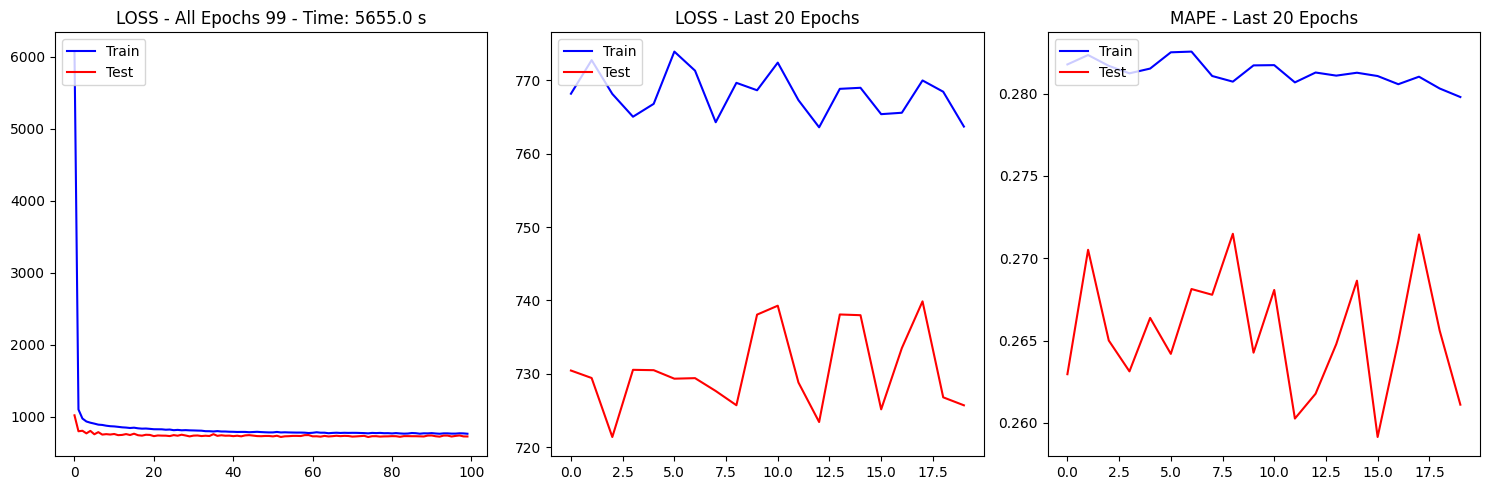

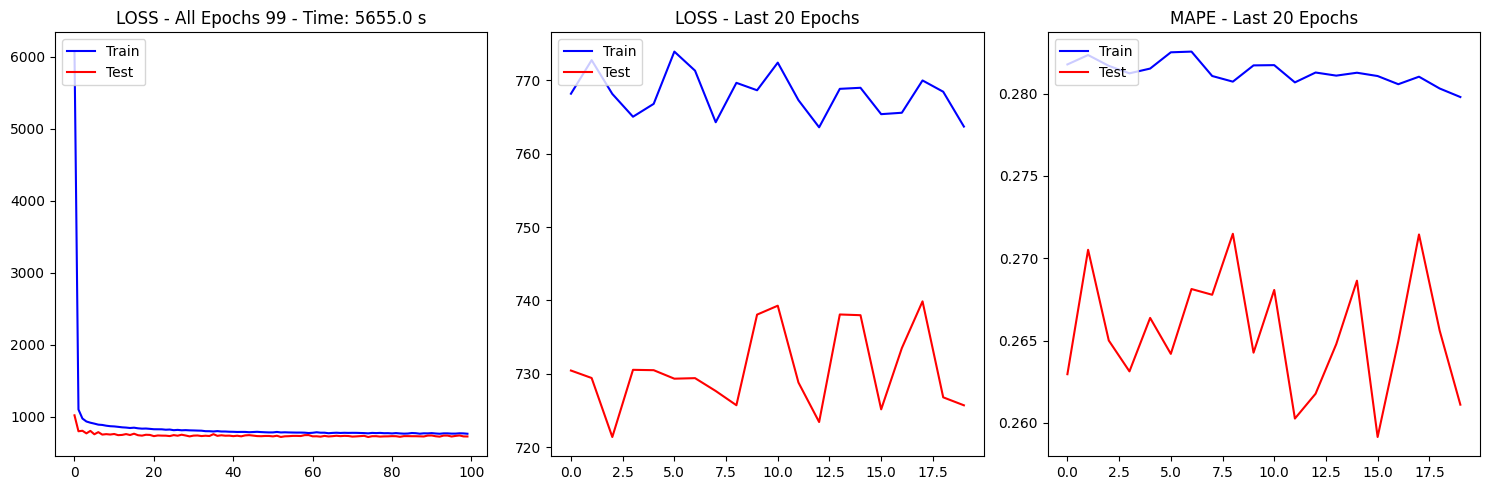

In [93]:
#ds = pems.get_fewsensors_dataset([311930, 312564, 312807, 312900, 313172, 314697, 315938, 317141, 318135, 318443 ], dtype=torch.float32, behavior='selfsupervised')
#ds = pems.get_sensor_dataset(311930, dtype=torch.float32, behavior='nondeterministic')
ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
                                       dtype=torch.float32,
                                       behavior='selfsupervised')

ds = ds.to(DEVICE)

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = 2, num_heads = 4, feed_forward = 256, transformer_activation = nn.GELU(),
               mlp = 2, mlp_dim = 256, mlp_activation = nn.GELU(),
               device = DEVICE, dtype = torch.float32)

training_loop(DEVICE, ds, cm,  batch=2048, epochs=100, lr=0.001,
              checkpoint_file='cell_model_{}_{}_{}_{}_{}'.format(2,4,256,2,256))

In [ ]:
DEVICE

In [ ]:
ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
                                       dtype=torch.float64,
                                       behavior='selfsupervised')

ds = ds.to(DEVICE)

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = 4, num_heads = 16, feed_forward = 1024, transformer_activation = nn.GELU(),
               mlp = 2, mlp_dim = 1024, mlp_activation = nn.GELU(),
               device = DEVICE, dtype = torch.float64)

training_loop(DEVICE, ds, cm,  batch=2048, epochs=100, lr=0.001,
              checkpoint_file='cell_model_{}_{}_{}_{}_{}'.format(4,16,1024,2,1024))

In [ ]:
training_loop(DEVICE, ds, cm,  batch=2048, epochs=100, lr=0.00001,
              checkpoint_file='cell_model_{}_{}_{}_{}_{}'.format(4,16,1024,2,1024))

## Graph Cellular Automata

### GCA

In [ ]:
def get_timestamp(start_ts, increment_type, increment):
  days = increment if increment_type == 'days' else 0
  seconds = increment if increment_type == 'seconds' else 0
  microseconds = increment if increment_type == 'microseconds' else 0
  milliseconds = increment if increment_type == 'milliseconds' else 0
  minutes = increment if increment_type == 'minutes' else 0
  hours = increment if increment_type == 'hours' else 0
  weeks = increment if increment_type == 'weeks' else 0
  delta = timedelta(days=days, seconds=seconds, microseconds=microseconds, 
                    milliseconds=milliseconds, minutes=minutes, hours=hours, weeks=weeks) 
  return start_ts + delta

def timestamp_generator(start_ts, iterations, increment_type='minutes', step=1):
  for i in range(0, iterations, step):
    yield get_timestamp(start_ts, increment_type, i)

class GraphCellularAutomata(nn.Module):
  def __init__(self, **kwargs):
    super().__init__()

    self.device = kwargs.get('device','cpu')
    self.dtype = kwargs.get('dtype',torch.float32)

    self.graph : nx.Graph = kwargs.get('graph',None)

    self.nodes : list = sorted([k for k in self.graph.nodes()])

    self.num_nodes = len(self.nodes)
    self.max_length = kwargs.get('max_length',None)
    self.token_size = kwargs.get('token_size',None)

    self.tokenizer : NeighborhoodTokenizer  = kwargs.get('tokenizer',None)

    self.tokenizer.graph = self.graph

    self.cell_model : nn.Module = kwargs.get('cell_model',None)

  def build_state(self, date, states) -> TensorDict:
    state = {'timestamp': date}
    for ix, node in enumerate(self.nodes):
      state[str(node)] = states[ix]
    return TensorDict(state)

  # For fine-tunning
  def forward(self, sequences, **kwargs):
    return self.cell_model.forward(sequences)
  
  def step(self, timestamp, current_state):
    tokens = torch.empty(self.num_nodes, self.max_length, self.token_size, dtype=self.dtype, device=self.device)
    for ix, node in enumerate(self.nodes):
      tokens[ix, :, :] = self.tokenizer.tokenize(timestamp, current_state, node)
    return self.forward(tokens) 
  
  def run(self, initial_date, initial_state, iterations, increment_type='minute', increment=1, **kwargs) -> torch.Tensor:
    return_type = kwargs.get('return_type','tensordict')
    current_state = TensorDict(initial_state)
    if return_type == 'tensordict':
      state_history = []
    else:
      state_history = torch.zeros(self.num_nodes * iterations, dtype=self.dtype, device=self.device)
    for ix, ts in enumerate(timestamp_generator(initial_date, iterations, increment_type, increment), start=1):
      result = self.step(ts, current_state)
      new_state = self.build_state(ts, result) 
      current_state = new_state

      if return_type == 'tensordict':
        state_history.append(new_state)
      else:
        state_history[self.num_nodes * (ix-1) : self.num_nodes * ix] = result

    return state_history
  
  def to(self, *args, **kwargs):
    self = super().to(*args, **kwargs)
    if isinstance(args[0], str):
      self.device = args[0]
    else:
      self.dtype = args[0]
    self.tokenizer = self.tokenizer.to(*args, **kwargs)
    self.cell_model = self.cell_model.to(*args, **kwargs)
    return self

  def train(self, *args, **kwargs):
    super().train(*args, **kwargs)
    self.cell_model = self.cell_model.train(*args, **kwargs)
    return self
  
  def parameters(self, recurse: bool = True):
    return self.cell_model.parameters(recurse)

    

### FineTunning

### Dataset

In [ ]:
class FineTunningDataset(Dataset):
  def __init__(self, pems, sensors, **kwargs):
    super().__init__()

    self.pems = pems
    self.sensors = sensors
    self.num_nodes = len(sensors)
    self.increment_type = kwargs.get('increment_type','minute')
    self.increment = kwargs.get('increment',1)
    self.steps_ahead = kwargs.get('steps_ahead',10)

  def __getitem__(self, date):
    if isinstance(date, datetime):
      dt1 = from_datetime_to_np(date)
      dt2 = from_datetime_to_np(get_timestamp(date, self.increment_type, self.increment))
    elif isinstance(date, np.datetime64):
      dt1 = date
      dt2 = from_datetime_to_np(get_timestamp(from_np_to_datetime(date), self.increment_type, self.increment))

    X = {'timestamp': dt1}
    df1 = self.pems.data[(self.pems.data['timestamp'] == dt1)]
    for ix, node in enumerate(self.sensors):
      X[str(node)] = df1[str(node)].values[0]

    y = torch.zeros(self.num_nodes * self.steps_ahead, dtype=self.pems.dtype, device=self.pems.device)

    for ct in range(0,self.steps_ahead):
      dt2 = from_datetime_to_np(get_timestamp(from_np_to_datetime(date), self.increment_type, self.increment))
      df2 = self.pems.data[(self.pems.data['timestamp'] == dt2)]

      for ix, node in enumerate(self.sensors):
        y[ct * self.num_nodes + ix] = df2[str(node)].values[0]

      date = from_np_to_datetime(dt2)
     
    return X,y

  def __len__(self):
    return self.pems.num_samples

  def __iter__(self):
    for date in self.pems.data['timestamp']:
      yield self[date]

  def to(self, *args, **kwargs):
    if isinstance(args[0], str):
      self.device = args[0]
    else:
      self.dtype = args[0]
    self.pems = self.pems.to(*args, **kwargs)
    return self

### Finetunning Loop

In [ ]:
def fine_tune(model, dataset, **kwargs):
    loss = nn.MSELoss()
    lr = kwargs.get('lr',0.001)
    epochs = kwargs.get('epochs', None)
    dataset = kwargs.get('dataset', None)
    batch = kwargs.get('batch', 256)
    optimizer = optim.Adam(self.cell_model.parameters(), lr = lr)
    current_state = TensorDict(initial_state)
    state_history = []
    losses = []
    for ts in timestamp_generator(initial_date, iterations, increment_type, increment):
        result = self.step(ts, current_state)

    return state_history

### Experiments

In [55]:
ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
                                       dtype=torch.float64,
                                       behavior='deterministic')

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = 2, num_heads = 4, feed_forward = 256, transformer_activation = nn.GELU(),
               mlp = 2, mlp_dim = 256, mlp_activation = nn.GELU(),
               device = DEVICE, dtype = torch.float32)

resume(cm,'cell_model_{}_{}_{}_{}_{}'.format(2,4,256,2,256))

subgraph = pems.G.subgraph(sensors)

gca = GraphCellularAutomata(device=cm.device, dtype=cm.dtype, graph = subgraph,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = cm)

dt = datetime(year=2018, month=9, day=1, hour=23, minute=0)

df = pems.data[(pems.data['timestamp'] == from_datetime_to_np(dt))]

initial_state = {}
for sensor in subgraph.nodes():
    initial_state[str(sensor)] = df[str(sensor)].values[0]

print(initial_state)

gca.run(dt, initial_state, 10, 'minute', 5)



{'313190': 24.0, '314697': 68.0, '314730': 60.0, '314698': 26.0, '313166': 22.0, '315827': 6.0, '313172': 27.0, '315828': 0.0, '315830': 25.0, '315831': 25.0}
tensor([[ 71.3329],
        [173.2419],
        [106.1022],
        [ 51.2456],
        [ 94.7038],
        [105.5363],
        [ 61.9104],
        [185.8214],
        [ 68.8892],
        [ 87.6868]], grad_fn=<GeluBackward0>)
tensor([[ 71.8067],
        [ 64.8436],
        [ 51.8746],
        [ 94.0661],
        [ 40.2647],
        [171.8164],
        [ 42.4658],
        [115.5831],
        [ 33.0372],
        [ 91.8894]], grad_fn=<GeluBackward0>)


C:\Users\petro\AppData\Local\Temp\ipykernel_28564\2097255585.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  return np.datetime64(date.astimezone(timezone.utc))


[TensorDict(
     fields={
         313166: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         313172: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         313190: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         314697: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         314698: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         314730: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         315827: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         315828: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         315830: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         315831: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=F